# Resizing DBM Dataset Images

### Mounting drive to upload files from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Importing the required libraries for the code

In [ ]:
import os
import numpy as np
import xml.etree
from numpy import zeros, asarray

### Uploading DBM dataset file (with images and XML files) and visualize & utils Python files

In [ ]:
!pip install mrcnn
import mrcnn

!unzip "//gdrive//My Drive//DBM Mask RCNN//Updated New Data.zip"
!cp "/gdrive/My Drive/DBM Mask RCNN/utils.py" "utils.py"
!cp "/gdrive/My Drive/DBM Mask RCNN/visualize.py" "visualize.py"
import utils
import visualize

     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp37-none-any.whl size=54930 sha256=18000a2fa5b245a2df43a847fbc1f833470e44ac6364c8376510bef0fd502d4b
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn
Archive:  //gdrive//My Drive//DBM Mask RCNN//Updated New Data.zip
   creating: Updated New Data/
   creating: Updated New Data/annots/
  inflating: Updated New Data/annots/1.xml  
  inflating: Updated New Data/annots/10.xml  
  inflating: Updated New Data/annots/100.xml  
  inflating: Updated New Data/annots/101.xml  
  inflating: Updated New Data/annots/102.xml  
  inflating: Updated New Data/annots/103.xml  
  inflating: Updated New Data/annots/104.xml  
  inflating: Updated New Data/annots/105.xml  
  inflating: Updated New Data/annots/106.xml  
  inflating: Updated New Data/annots/107.xml  
  inflating: Updated New Data/annots/108.xml  
  inflating: Updat

### DBM Dataset

In [ ]:
class DBMDataset(utils.Dataset):

  def load_dataset(self, dataset_dir):
    self.add_class("dataset", 1, "DBM")
    
    images_dir = dataset_dir + '//images//'
    annotations_dir = dataset_dir + '//annots//'
    
    for filename in os.listdir(images_dir):
      image_id = filename.split('.')[0]

      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.xml'
      
      self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path)

  def extract_boxes(self, filename):
    tree = xml.etree.ElementTree.parse(filename)
    root = tree.getroot()
    
    boxes = list()
    for box in root.findall('.//bndbox'):
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)
      coors = [xmin, ymin, xmax, ymax]
      boxes.append(coors)
    
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height
    
  def load_mask(self, image_id):
    info = self.image_info[image_id]
    #print(info)
    path = info['annotation']
    #print(path)
    boxes, w, h = self.extract_boxes(path)
    masks = zeros([h, w, len(boxes)], dtype = 'uint8')

    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('DBM'))
    return masks, asarray(class_ids, dtype = 'int32')

### Prepare the dataset with all the images

In [ ]:
dataset = DBMDataset()
dataset.load_dataset(dataset_dir = 'Updated New Data')
dataset.prepare()

### Importing libraries needed for the code below

In [ ]:
from pathlib import Path
#import xml.etree.cElementTree as ET
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt

### Create a labelImg compatible XML file using the bounding boxes coordinates

In [ ]:
x_length = []
y_length = []
both_length = []

In [ ]:
def create_labelimg_xml(image_path):

  image_path = Path(image_path)
  img = np.array(Image.open(image_path).convert('RGB'))

  annotation = ET.Element('annotation')
  ET.SubElement(annotation, 'folder').text = str(image_path.parent.name)
  ET.SubElement(annotation, 'filename').text = str(image_path.name)
  ET.SubElement(annotation, 'path').text = str(image_path)

  source = ET.SubElement(annotation, 'source')
  ET.SubElement(source, 'database').text = 'Unknown'

  size = ET.SubElement(annotation, 'size')
  ET.SubElement(size, 'width').text = str(img.shape[1])
  ET.SubElement(size, 'height').text = str(img.shape[0])
  ET.SubElement(size, 'depth').text = str(img.shape[2])

  ET.SubElement(annotation, 'segmented').text = '0'

  for box in bbox:
    xmin, ymin, xmax, ymax = box[1], box[0], box[3], box[2]

    object = ET.SubElement(annotation, 'object')
    ET.SubElement(object, 'name').text = 'DBM'
    ET.SubElement(object, 'pose').text = 'Unspecified'
    ET.SubElement(object, 'truncated').text = '0'
    ET.SubElement(object, 'difficult').text = '0'

    bndbox = ET.SubElement(object, 'bndbox')
    ET.SubElement(bndbox, 'xmin').text = str(xmin)
    ET.SubElement(bndbox, 'ymin').text = str(ymin)
    ET.SubElement(bndbox, 'xmax').text = str(xmax)
    ET.SubElement(bndbox, 'ymax').text = str(ymax)

    x_diff = xmax - xmin
    y_diff = ymax - ymin

    if x_diff != 0:
      x_length.append(x_diff)
      both_length.append(x_diff)
    if y_diff != 0:
      y_length.append(y_diff)
      both_length.append(y_diff)

  tree = ET.ElementTree(annotation)
  tree.write('/gdrive/My Drive/DBM Mask RCNN/resizedUpdatedNewData/annots/%s.xml' % str(image_id + 1))

### Creating a **resizedDBM** folder with **images** and **annots** subfolders

In [ ]:
os.makedirs('/gdrive/My Drive/DBM Mask RCNN/resizedUpdatedNewData')
os.makedirs('/gdrive/My Drive/DBM Mask RCNN/resizedUpdatedNewData/images')
os.makedirs('/gdrive/My Drive/DBM Mask RCNN/resizedUpdatedNewData/annots')

### Resize the images and save the generated images and XML files

In [ ]:
for image_id in dataset.image_ids:
  image = dataset.load_image(image_id)

  #fig, axes = plt.subplots(1, 2, figsize=(8, 4))
  #ax = axes.ravel()

  #ax[0].set_title('Original Image')
  #ax[0].imshow(image)

  #print("dataset.image_ids:", dataset.image_ids)
  print("image_id:", image_id)
  mask, class_ids = dataset.load_mask(int(image_id))

  image, window, scale, padding, _ = utils.resize_image(image, 
                                                        min_dim=1024, 
                                                        max_dim=1024, 
                                                        mode="square")

  mask = utils.resize_mask(mask, scale, padding)
  bbox = utils.extract_bboxes(mask)

  #ax[1].set_title('Resized Image')
  #ax[1].imshow(image)

  #plt.tight_layout()
  #plt.show()

  #visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

  im = Image.fromarray(image)
  im.save('/gdrive/My Drive/DBM Mask RCNN/resizedUpdatedNewData/images/%s.jpg' % str(image_id + 1))
  create_labelimg_xml('/gdrive/My Drive/DBM Mask RCNN/resizedUpdatedNewData/images/%s.jpg' % str(image_id + 1))

image_id: 0
image_id: 1
image_id: 2
image_id: 3
image_id: 4
image_id: 5
image_id: 6
image_id: 7
image_id: 8
image_id: 9
image_id: 10
image_id: 11
image_id: 12
image_id: 13
image_id: 14
image_id: 15
image_id: 16
image_id: 17
image_id: 18
image_id: 19
image_id: 20
image_id: 21
image_id: 22
image_id: 23
image_id: 24
image_id: 25
image_id: 26
image_id: 27
image_id: 28
image_id: 29
image_id: 30
image_id: 31
image_id: 32
image_id: 33
image_id: 34
image_id: 35
image_id: 36
image_id: 37
image_id: 38
image_id: 39
image_id: 40
image_id: 41
image_id: 42
image_id: 43
image_id: 44
image_id: 45
image_id: 46
image_id: 47
image_id: 48
image_id: 49
image_id: 50
image_id: 51
image_id: 52
image_id: 53
image_id: 54
image_id: 55
image_id: 56
image_id: 57
image_id: 58
image_id: 59
image_id: 60
image_id: 61
image_id: 62
image_id: 63
image_id: 64
image_id: 65
image_id: 66
image_id: 67
image_id: 68
image_id: 69
image_id: 70
image_id: 71
image_id: 72
image_id: 73
image_id: 74
image_id: 75
image_id: 76
image_id:

The newly generated images and XML files can be found in the resizedDBM folder's subfolders images and annots respectively. Download the resizedDBM folder to get a resizedDBM.zip file, which will be used in the DBM Mask R-CNN main code

### Getting statistics about the length of bounding boxes

In [ ]:
import statistics

In [ ]:
print(x_length)
print("mean x_length: ", np.mean(x_length))
print("Biggest x_length: ", max(x_length))
print("Smallest x_length: ", min(x_length))
print("Median x_length: ", statistics.median(x_length))
print("Std Dev x_length: ", np.std(x_length))

print(y_length)
print("mean y_length: ", np.mean(y_length))
print("Biggest y_length: ", max(y_length))
print("Smallest y_length: ", min(y_length))
print("Median y_length: ", statistics.median(y_length))
print("Std Dev y_length: ", np.std(y_length))

print(both_length)
print("mean both_length: ", np.mean(both_length))
print("Biggest both_length: ", max(both_length))
print("Smallest both_length: ", min(both_length))
print("Median both_length: ", statistics.median(both_length))
print("Std Dev both_length: ", np.std(both_length))

[37, 40, 21, 34, 28, 32, 37, 28, 34, 37, 32, 32, 25, 21, 13, 23, 14, 32, 37, 33, 43, 38, 23, 27, 28, 38, 35, 35, 34, 26, 45, 41, 40, 33, 42, 40, 43, 27, 32, 24, 36, 30, 37, 35, 27, 32, 37, 34, 29, 33, 34, 34, 34, 29, 31, 40, 36, 37, 33, 34, 29, 37, 34, 39, 31, 37, 26, 35, 27, 30, 28, 30, 45, 32, 29, 41, 32, 29, 27, 36, 35, 37, 21, 33, 18, 26, 23, 24, 37, 25, 26, 19, 24, 30, 30, 13, 25, 31, 29, 25, 29, 31, 24, 24, 27, 29, 25, 24, 34, 20, 39, 28, 33, 34, 18, 21, 29, 27, 26, 16, 28, 31, 38, 19, 25, 23, 29, 21, 37, 25, 38, 37, 27, 23, 19, 25, 20, 17, 31, 27, 30, 20, 24, 34, 24, 25, 32, 18, 23, 26, 23, 30, 21, 23, 25, 23, 20, 27, 28, 26, 36, 31, 20, 32, 29, 24, 22, 26, 36, 23, 12, 15, 14, 21, 40, 26, 28, 24, 28, 31, 19, 46, 25, 33, 19, 23, 24, 22, 29, 29, 35, 16, 34, 16, 25, 20, 29, 29, 23, 30, 32, 19, 24, 27, 33, 31, 25, 35, 34, 21, 27, 29, 29, 31, 18, 32, 43, 23, 32, 30, 39, 36, 33, 25, 23, 26, 38, 30, 32, 21, 23, 27, 28, 33, 20, 18, 28, 27, 25, 29, 25, 28, 28, 28, 23, 34, 28, 26, 20, 25,

### Plotting the deviation of the lengths

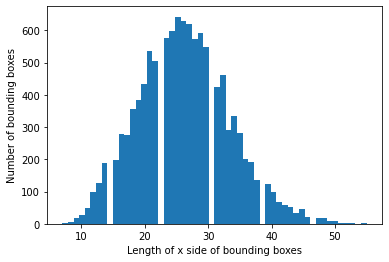

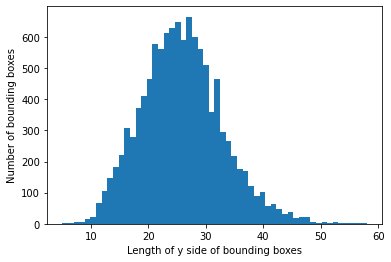

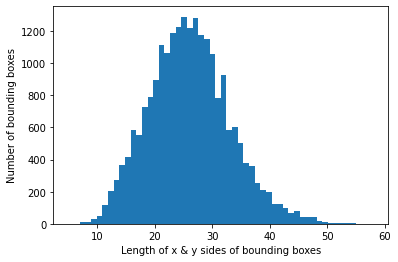

In [ ]:
plt.hist(x_length, bins=54)
plt.xlabel("Length of x side of bounding boxes")
plt.ylabel("Number of bounding boxes")
plt.show()

plt.hist(y_length, bins=54)
plt.xlabel("Length of y side of bounding boxes")
plt.ylabel("Number of bounding boxes")
plt.show()

plt.hist(both_length, bins=54)
plt.xlabel("Length of x & y sides of bounding boxes")
plt.ylabel("Number of bounding boxes")
plt.show()